# Classification of MNIST dataset


In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import autograd.numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn


# Custom imports
from mnist_preprocessing import X_train, X_test, y_train, y_test, ITERATIONS, MNIST_RANDOM_STATE, TORCH_SEED, HIDDEN_LAYERS, BATCH_SIZE, ETA_VALUES, LAMBDA_VALUES, MOMENTUM


## Classification of MNIST dataset with PyTorch


In [2]:
# Construct PyTorch model

def create_model(hidden_layers, X_train):
    """
    Constructs a feedforward neural network using PyTorch with specified hidden layers.

    Parameters:
    ----------
    hidden_layers : list of int
        A list specifying the number of units in each hidden layer.
    X_train : array-like
        Training data used to determine the input size of the model.

    Returns:
    -------
    nn.Sequential
        A PyTorch sequential model consisting of:
        - Flatten layer
        - One or more hidden layers with ReLU activation
        - Final output layer with 10 units (for classification into 10 classes)
    """

    hidden_units = hidden_layers
    input_size = X_train[1].shape[0]

    all_layers = [nn.Flatten()]
    for hidden_unit in hidden_units:
        layer = nn.Linear(input_size, hidden_unit)
        all_layers.append(layer)
        all_layers.append(nn.ReLU())
        input_size = hidden_unit
    all_layers.append(nn.Linear(hidden_units[-1], 10))
    model_layers = nn.Sequential(*all_layers)
    model_layers

    return model_layers




# function to evaluvate hyperparameters
def pytorch_mnist(nn_model, hidden_layers, batch_size, torch_seed, X_train, y_train, X_test, y_test, optimizer_name, max_iterations, penalty, etas, lambdas, momentum_number, verbose=True):
    """
    Docstring created with Copilot
    Modifications of code from:
        @book{raschka2022mlpytorch-mnist,
        address = {https://sebastianraschka.com/blog/2022/ml-pytorch-book.html},
        author = {Raschka, Sebastian and Liu, Yuxi and Mirjalili, Vahid},
        date-added = {2025-10-27 12:24:45 +0100},
        date-modified = {2025-10-31 12:25:38 +0100},
        keywords = {Accessed October 2025},
        publisher = {Packt Publishing},
        read = {1},
        pages = {437-439},
        title = {Machine Learning with PyTorch and Scikit-Learn},
        year = {2022}}


    Trains a PyTorch neural network model on MNIST-like data using various hyperparameter combinations.

    Parameters:
    ----------
    nn_model : callable
        A function or class that returns a PyTorch model when called with `hidden_layers` and `X_train`.
    hidden_layers : list or tuple
        Configuration of hidden layers for the neural network.
    batch_size : int
        Number of samples per batch for training.
    torch_seed : int
        Random seed for PyTorch to ensure reproducibility.
    X_train : array-like
        Training feature data.
    y_train : array-like
        Training labels.
    X_test : array-like
        Test feature data.
    y_test : array-like
        Test labels.
    optimizer_name : str
        Name of the optimizer to use. Options: 'ADAM', 'SGD', 'RMSProp', 'Adagrad'.
    max_iterations : int
        Number of training epochs.
    penalty : str
        Regularization type (e.g., 'l2'). Currently used to determine weight decay.
    etas : list of float
        Learning rates to try.
    lambdas : list of float
        Regularization strengths (weight decay) to try.
    momentum_number : float
        Momentum value for optimizers that support it (SGD, RMSProp).
    verbose : bool, optional
        If True, prints training progress and test accuracy.

    Returns:
    -------
    pd.DataFrame
        A DataFrame containing the learning rate, lambda, test accuracy, and predicted test outputs
        for each combination of hyperparameters.
    """

    
    torch.manual_seed(torch_seed)

    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train = np.array(y_train, dtype=np.int64)
    y_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test = np.array(y_test, dtype=np.int64)
    #y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_dl = DataLoader(train_dataset, batch_size, shuffle=True)

    results = []

    for eta in etas:
        for lmbd in lambdas:
            
            if verbose:
                print(f"\nTraining with lr={eta}, lambda={lmbd}, optimizer={optimizer_name}, penalty={penalty}")

            model = nn_model(hidden_layers, X_train)
            print(model) # Just to print model
            loss_fn = nn.CrossEntropyLoss()

            if optimizer_name == 'ADAM':
                optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=lmbd)
            elif optimizer_name == 'SGD':
                optimizer = torch.optim.SGD(model.parameters(), lr=eta, weight_decay=lmbd, momentum=momentum_number)
            elif optimizer_name == 'RMSProp':
                optimizer = torch.optim.RMSprop(model.parameters(), lr=eta, weight_decay=lmbd, momentum=momentum_number)
            elif optimizer_name == 'Adagrad':
                optimizer = torch.optim.Adagrad(model.parameters(), lr=eta, weight_decay=lmbd)

            epoch_accuracy_list = []
            for epoch in range(max_iterations):
                accuracy_hist_train = 0
                for x_batch, y_batch in train_dl:
                    pred = model(x_batch)
                    loss = loss_fn(pred, y_batch)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    is_correct = (
                        torch.argmax(pred, dim=1) == y_batch
                        ).float()
                    accuracy_hist_train += is_correct.sum()
                accuracy_hist_train /= len(train_dl.dataset)
                epoch_accuracy_list.append(accuracy_hist_train.item())
                if verbose: print(f'Epoch {epoch} Accuracy {accuracy_hist_train:.4f}')

            y_predicted = model(X_test_tensor)
            is_correct = (
                torch.argmax(y_predicted, dim=1) == y_test).float().mean().item()

            if verbose: print(f'Test accuracy: {is_correct:.4f}')

            results.append({
                'Learning Rate': eta,
                'Lambda': lmbd,
                'Accuracy': is_correct,
                'Epoch accuracy': epoch_accuracy_list,
                'y_predict': y_predicted
            })
    return pd.DataFrame(results)




In [3]:
# Run PyTorch on MNIST with diffent optimizers and hyperparameteres
#sgd_mnist = pytorch_mnist(create_model, HIDDEN_LAYERS ,BATCH_SIZE, TORCH_SEED, X_train, y_train, X_test, y_test, 'SGD', ITERATIONS, 'l2', ETA_VALUES, LAMBDA_VALUES, MOMENTUM, verbose=True)
#adagrad_mnist = pytorch_mnist(create_model, HIDDEN_LAYERS ,BATCH_SIZE, TORCH_SEED, X_train, y_train, X_test, y_test, 'Adagrad', ITERATIONS, 'l2', ETA_VALUES, LAMBDA_VALUES, MOMENTUM, verbose=True)
#rmsprop_mnist = pytorch_mnist(create_model, HIDDEN_LAYERS ,BATCH_SIZE, TORCH_SEED, X_train, y_train, X_test, y_test, 'RMSProp', ITERATIONS, 'l2', ETA_VALUES, LAMBDA_VALUES, MOMENTUM, verbose=True)
adam_mnist = pytorch_mnist(create_model, HIDDEN_LAYERS ,BATCH_SIZE, TORCH_SEED, X_train, y_train, X_test, y_test, 'ADAM', ITERATIONS, 'l2', ETA_VALUES, LAMBDA_VALUES, MOMENTUM, verbose=True)



Training with lr=0.1, lambda=0.01, optimizer=ADAM, penalty=l2
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)
Epoch 0 Accuracy 0.3317
Epoch 1 Accuracy 0.5277
Epoch 2 Accuracy 0.5491
Epoch 3 Accuracy 0.5971
Test accuracy: 0.5726

Training with lr=0.1, lambda=0.005994842503189409, optimizer=ADAM, penalty=l2
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)
Epoch 0 Accuracy 0.1954
Epoch 1 Accuracy 0.3069
Epoch 2 Accuracy 0.3894
Epoch 3 Accuracy 0.3560
Test accuracy: 0.2019

Training with lr=0.1, lambda=0.003593813663804626, optimizer=ADAM, penalty=l2
Sequential(
  (0): Flatten(st

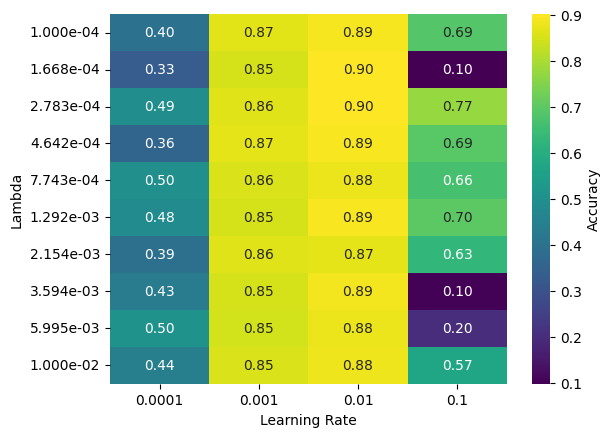

<Figure size 1200x600 with 0 Axes>

In [4]:
# Plotting heatmaps
from plotting import plot_heatmap

#plot_heatmap(sgd_mnist, 'Accuracy')
#plot_heatmap(adagrad_mnist, 'Accuracy')
#plot_heatmap(rmsprop_mnist, 'Accuracy')
plot_heatmap(adam_mnist, 'Accuracy')

## Classification of MNIST dataset with LogisticRegression from Scikit-learn

In [5]:
# Initialize the model
model = LogisticRegression(solver='saga', max_iter=ITERATIONS, random_state=MNIST_RANDOM_STATE)
# Train the model
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")



Model Accuracy: 0.8950


c:\Users\brumor\python_env\4155\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
